   # **Perth House Price prediction project**

*In this notebook, I am glad to show you how to understand data and apply it to the Machine Learning model.
Also, I'll show how to visualize Latitude and Longitude on a map, how to deal with categorical data and deal with distributions in numerical data.
Then, I'll demonstrate how to work and test 7 ML models at a time and choose the best one. I hope you enjoy it!
Finally we can see the results and their accuracy is 84%.*

![](https://th.bing.com/th/id/OIP.yk4Bm3kehjEu3mTZewa1xQHaD4?w=341&h=180&c=7&r=0&o=5&pid=1.7)

# Overview

**1. First look at the DATA and simple EDA**

**2. Data Cleaning**

**3. Data Visualization(heatmap, histograms)**

**4. Visualizing Geographical Data (Visualizing how the price increase and decrease by location)**

**5. Creating new features based on the DATA. Experimenting with Attribute Combinations**

**6. Handling categorical and numerical data(creating preprocessor)**

**7. Models building and choosing the best model**

**8. Model Tuning**

**9. Results**

In [38]:
#importing libaries
import pandas as pd
import numpy as np

#data visualization libaries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#need to geografical data visualization(used in chapter 4)
from urllib.request import urlopen
import json

#need to deal with numerical and categorical data(used in chapter 6)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

import category_encoders as ce

pd.options.display.float_format = "{:.4f}".format
sns.set_style("darkgrid")
plt.style.use("fivethirtyeight")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# 1. First look at the DATA and simple EDA

In [4]:
all_data = pd.read_csv('data/perth_house_info.csv')
all_data.head(5)

,ADDRESS,SUBURB,PRICE,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN,NEAREST_STN_DIST,DATE_SOLD,POSTCODE,LATITUDE,LONGITUDE,NEAREST_SCH,NEAREST_SCH_DIST,NEAREST_SCH_RANK
0,1 Acorn Place,South Lake,565000,4,2,2.0000,600,160,2003.0000,18300,Cockburn Central Station,1800,09-2018\r,6164,-32.1159,115.8424,LAKELAND SENIOR HIGH SCHOOL,0.8283,NaN
1,1 Addis Way,Wandi,365000,3,2,2.0000,351,139,2013.0000,26900,Kwinana Station,4900,02-2019\r,6167,-32.1935,115.8596,ATWELL COLLEGE,5.5243,129.0000
2,1 Ainsley Court,Camillo,287000,3,1,1.0000,719,86,1979.0000,22600,Challis Station,1900,06-2015\r,6111,-32.1206,115.9936,KELMSCOTT SENIOR HIGH SCHOOL,1.6492,113.0000
3,1 Albert Street,Bellevue,255000,2,1,2.0000,651,59,1953.0000,17900,Midland Station,3600,07-2018\r,6056,-31.9005,116.0380,SWAN VIEW SENIOR HIGH SCHOOL,1.5714,NaN
4,1 Aman Place,Lockridge,325000,4,1,2.0000,466,131,1998.0000,11200,Bassendean Station,2000,11-2016\r,6054,-31.8858,115.9478,KIARA COLLEGE,1.5149,NaN


In [5]:
#create a func for in-depth data understanding

def EDA(data):

    shape_info = data.shape

    print('EXPLORATORY DATA ANALYSIS:\n')

    print(f'Numbers of rows: {shape_info[0]} \nNumbers of columns:  {shape_info[1]}\n',
    '\n------------------------------------------------------------------------------------\n')

    print(f'All columns from the dataframe :\n\n {data.columns}\n',
    '\n------------------------------------------------------------------------------------\n')

    print(f'Datatypes and Missing values:\n')
    print(data.info(),
    '\n------------------------------------------------------------------------------------\n')

    print('Summary statistics for the data :\n')
    print(data.describe(),
    '\n------------------------------------------------------------------------------------\n')

    print('MISSIN VALUES :\n')
    print(data.isnull().sum())
    
    
EDA(all_data)

EXPLORATORY DATA ANALYSIS:

Numbers of rows: 33656 
Numbers of columns:  19
 
------------------------------------------------------------------------------------

All columns from the dataframe :

 Index(['ADDRESS', 'SUBURB', 'PRICE', 'BEDROOMS', 'BATHROOMS', 'GARAGE',
       'LAND_AREA', 'FLOOR_AREA', 'BUILD_YEAR', 'CBD_DIST', 'NEAREST_STN',
       'NEAREST_STN_DIST', 'DATE_SOLD', 'POSTCODE', 'LATITUDE', 'LONGITUDE',
       'NEAREST_SCH', 'NEAREST_SCH_DIST', 'NEAREST_SCH_RANK'],
      dtype='object')
 
------------------------------------------------------------------------------------

Datatypes and Missing values:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33656 entries, 0 to 33655
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ADDRESS           33656 non-null  object 
 1   SUBURB            33656 non-null  object 
 2   PRICE             33656 non-null  int64  
 3   BEDROOMS          33656 

# 2. Data Cleaning

Handling with missing values(GARAGE, BUILD_YEAR, NEAREST_SCH_RANK)

1. Garage will be replaced by middle values(50%).

2. NEAREST_SCH_RANK column will be deleted from the dataset.

3. A 75% value will replace missing values from BUILD_YEAR.

In [6]:
#handling with missing values(GARAGE, BUILD_YEAR, NEAREST_SCH_RANK)
all_data['GARAGE'] = all_data['GARAGE'].fillna(all_data['GARAGE'].median())
all_data['BUILD_YEAR'] = all_data['BUILD_YEAR'].fillna(all_data['BUILD_YEAR'].quantile(0.75))
all_data = all_data.drop(['NEAREST_SCH_RANK'], axis=1)

all_data.isnull().sum()

ADDRESS             0
SUBURB              0
PRICE               0
BEDROOMS            0
BATHROOMS           0
GARAGE              0
LAND_AREA           0
FLOOR_AREA          0
BUILD_YEAR          0
CBD_DIST            0
NEAREST_STN         0
NEAREST_STN_DIST    0
DATE_SOLD           0
POSTCODE            0
LATITUDE            0
LONGITUDE           0
NEAREST_SCH         0
NEAREST_SCH_DIST    0
dtype: int64

 Handling with dtypes

1. GARAGE, BUILD_YEAR are float dtypes.

2. DATE_SOLD has extra character "/r" and object dtype.

In [7]:
#replace float dtype to int dtype in GARAGE and BUILD_YEAR
cols = ['GARAGE', 'BUILD_YEAR']
all_data[cols] = all_data[cols].applymap(np.int64)

#remove '\r' from DATE_SOLD values and formate it to datetime type
all_data['DATE_SOLD'] = all_data['DATE_SOLD'].str.replace('\r', '')
all_data['DATE_SOLD'] = pd.to_datetime(all_data['DATE_SOLD'])

all_data.dtypes

/var/folders/bs/l_b7zpn52534fb78lqz40tth0000gn/T/ipykernel_2398/3113441609.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  all_data['DATE_SOLD'] = pd.to_datetime(all_data['DATE_SOLD'])


ADDRESS                     object
SUBURB                      object
PRICE                        int64
BEDROOMS                     int64
BATHROOMS                    int64
GARAGE                       int64
LAND_AREA                    int64
FLOOR_AREA                   int64
BUILD_YEAR                   int64
CBD_DIST                     int64
NEAREST_STN                 object
NEAREST_STN_DIST             int64
DATE_SOLD           datetime64[ns]
POSTCODE                     int64
LATITUDE                   float64
LONGITUDE                  float64
NEAREST_SCH                 object
NEAREST_SCH_DIST           float64
dtype: object

In [42]:
# save data to csv file
all_data.to_csv('data/perth_house_info_cleaned.csv', index=False)

# 3. Data Visualization(heatmap, histograms)

Visualizing dataset:

1. Finding strong correlations

2. Visualizing histograms for all numerical columns

In [10]:
#Sumary statistics for the data
pd.set_option('display.max_columns', None)
summary_table = all_data.describe()
summary_table

,PRICE,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN_DIST,DATE_SOLD,POSTCODE,LATITUDE,LONGITUDE,NEAREST_SCH_DIST
count,33656.0000,33656.0000,33656.0000,33656.0000,33656.0000,33656.0000,33656.0000,33656.0000,33656.0000,33656,33656.0000,33656.0000,33656.0000,33656.0000
mean,637072.0058,3.6591,1.8231,2.1852,2740.6440,183.5015,1991.1401,19777.3745,4523.3715,2017-02-05 22:44:21.278821120,6089.4201,-31.9607,115.8793,1.8153
min,51000.0000,1.0000,1.0000,1.0000,61.0000,1.0000,1868.0000,681.0000,46.0000,1988-04-01 00:00:00,6003.0000,-32.4730,115.5827,0.0709
25%,410000.0000,3.0000,1.0000,2.0000,503.0000,130.0000,1980.0000,11200.0000,1800.0000,2015-11-01 00:00:00,6050.0000,-32.0684,115.7898,0.8806
50%,535500.0000,4.0000,2.0000,2.0000,682.0000,172.0000,1998.0000,17500.0000,3200.0000,2017-11-01 00:00:00,6069.0000,-31.9332,115.8542,1.3455
75%,760000.0000,4.0000,2.0000,2.0000,838.0000,222.2500,2005.0000,26600.0000,5300.0000,2019-06-01 00:00:00,6150.0000,-31.8438,115.9707,2.0972
max,2440000.0000,10.0000,16.0000,99.0000,999999.0000,870.0000,2017.0000,59800.0000,35500.0000,2020-12-01 00:00:00,6558.0000,-31.4575,116.3432,23.2544
std,355825.6327,0.7520,0.5874,1.3150,16693.5132,72.1030,20.4493,11364.4154,4495.0640,NaN,62.1679,0.1778,0.1181,1.7460


In [23]:
num_cols = list(all_data.select_dtypes(['int64', 'float64']))
print('Numerical Cols: ', num_cols,'\n')

cat_cols = list(all_data.select_dtypes(['object', 'datetime64[ns]']))
print('Object Cols:', cat_cols)

Numerical Cols:  ['PRICE', 'BEDROOMS', 'BATHROOMS', 'GARAGE', 'LAND_AREA', 'FLOOR_AREA', 'BUILD_YEAR', 'CBD_DIST', 'NEAREST_STN_DIST', 'POSTCODE', 'LATITUDE', 'LONGITUDE', 'NEAREST_SCH_DIST'] 

Object Cols: ['ADDRESS', 'SUBURB', 'NEAREST_STN', 'DATE_SOLD', 'NEAREST_SCH']


**1. Visualizing histograms & box plots for all numerical columns**

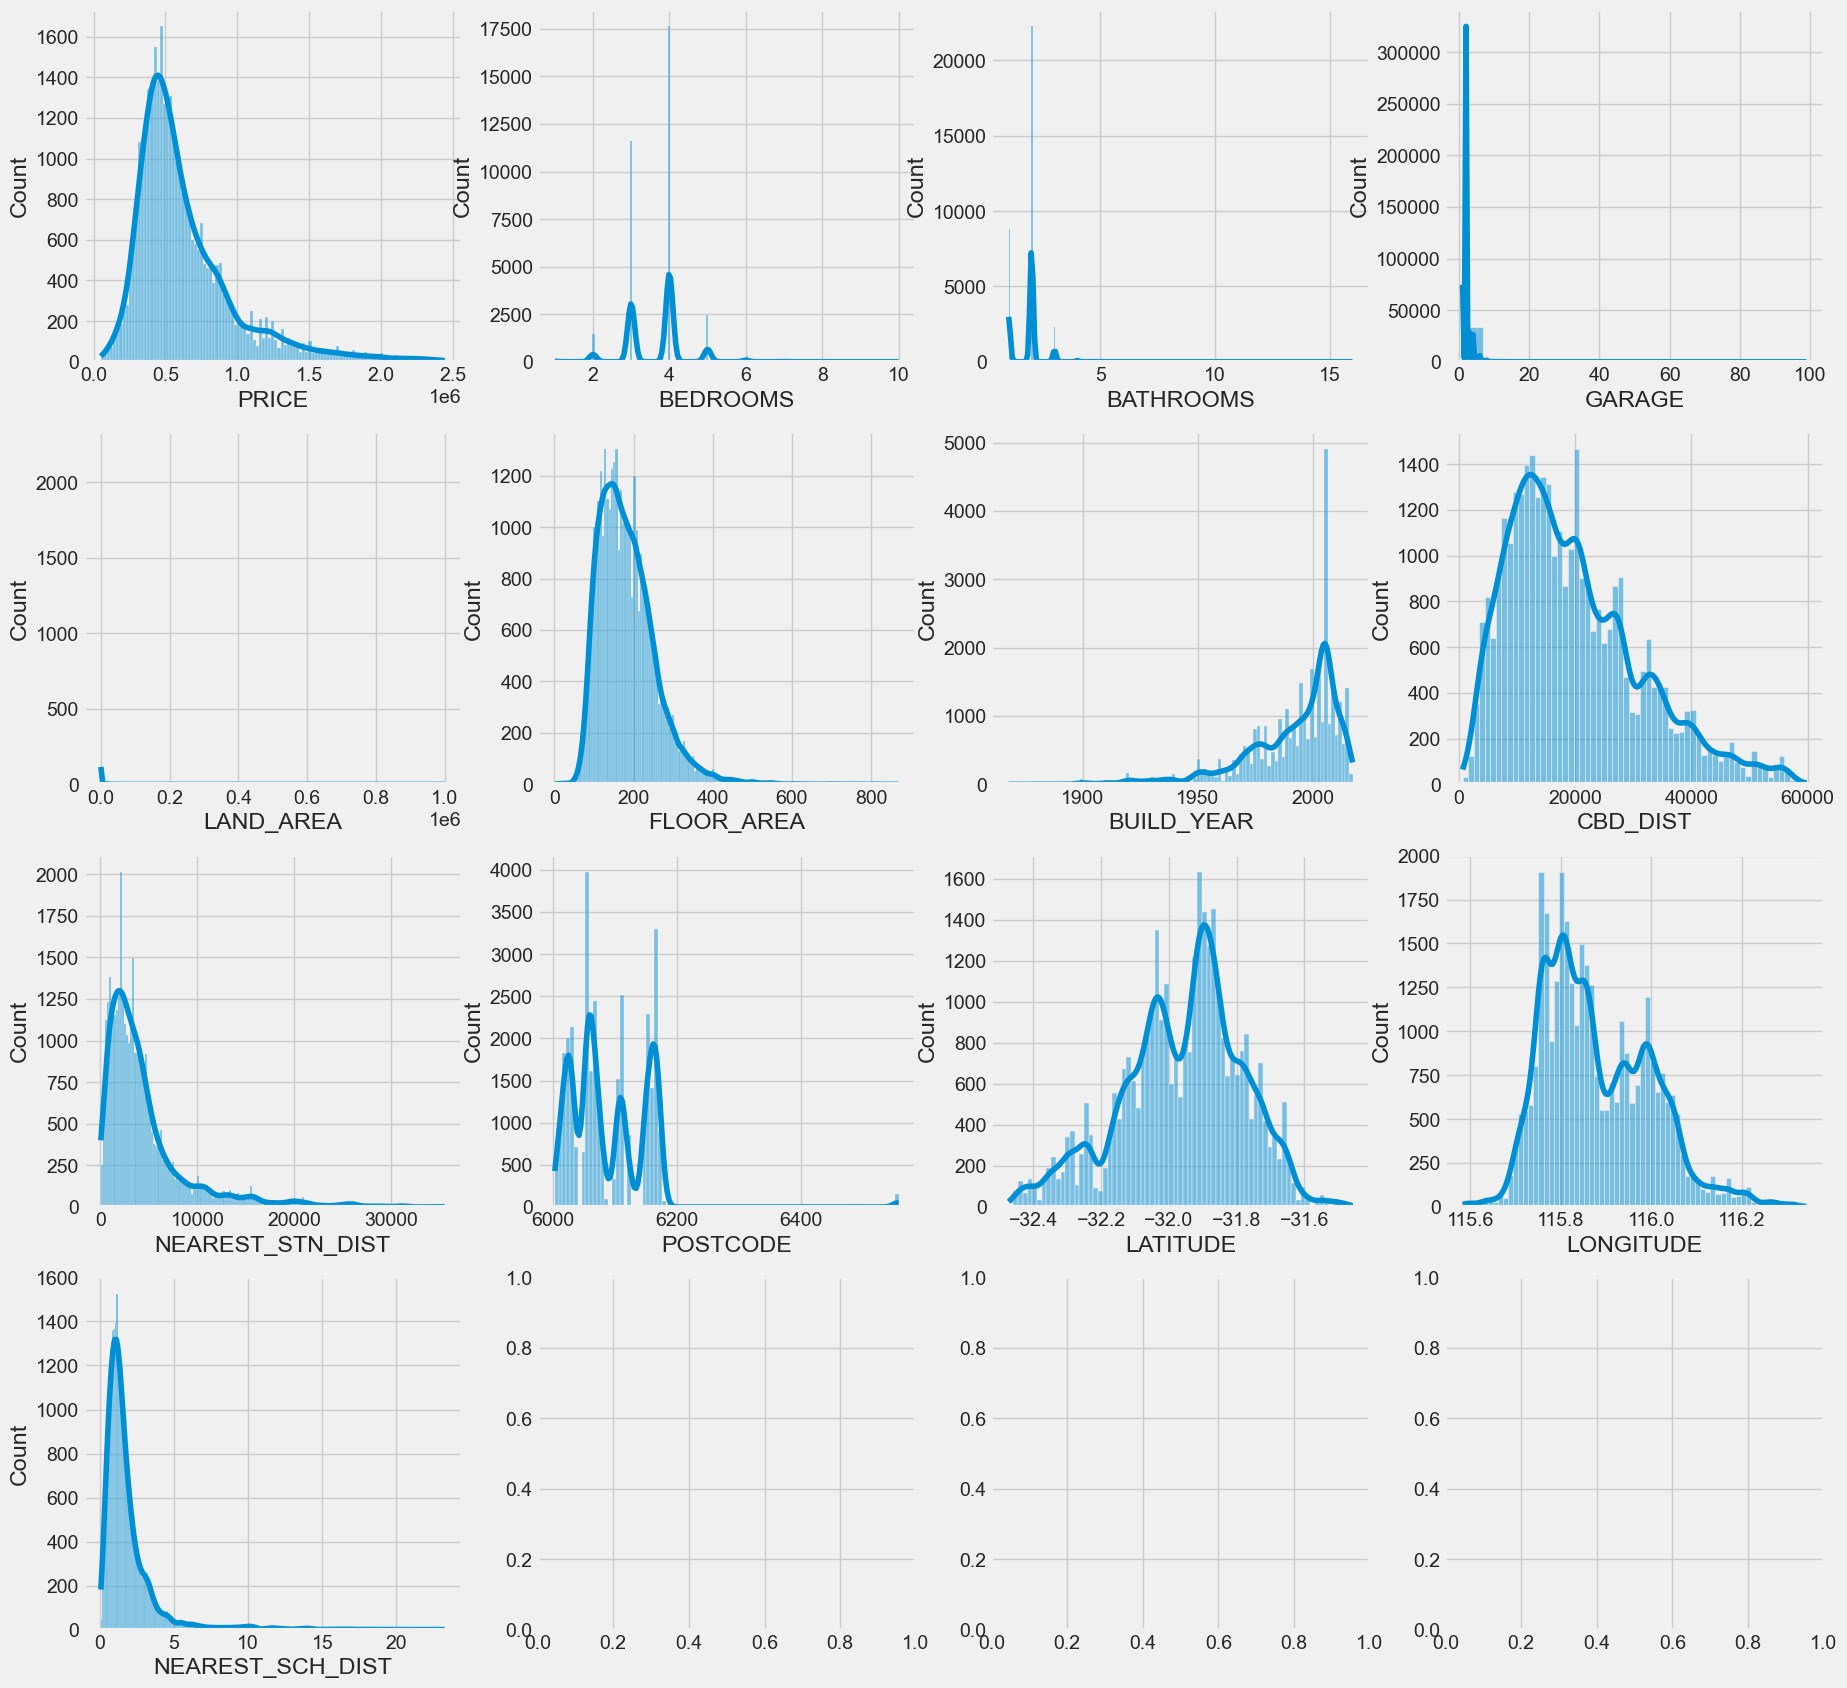

In [24]:
#num_cols =  ['PRICE', 'BEDROOMS', 'BATHROOMS', 'GARAGE', 'LAND_AREA', 'FLOOR_AREA', 'BUILD_YEAR', 'CBD_DIST', 'NEAREST_STN_DIST', 'POSTCODE', 'LATITUDE', 'LONGITUDE', 'NEAREST_SCH_DIST']
fig,ax=plt.subplots(4,4, figsize=(20,20))
for i,ax in zip(num_cols,ax.ravel()):
    sns.histplot(all_data, x=i, kde=True, ax=ax)
    #plt.title("Histogram of" +i)
plt.show()

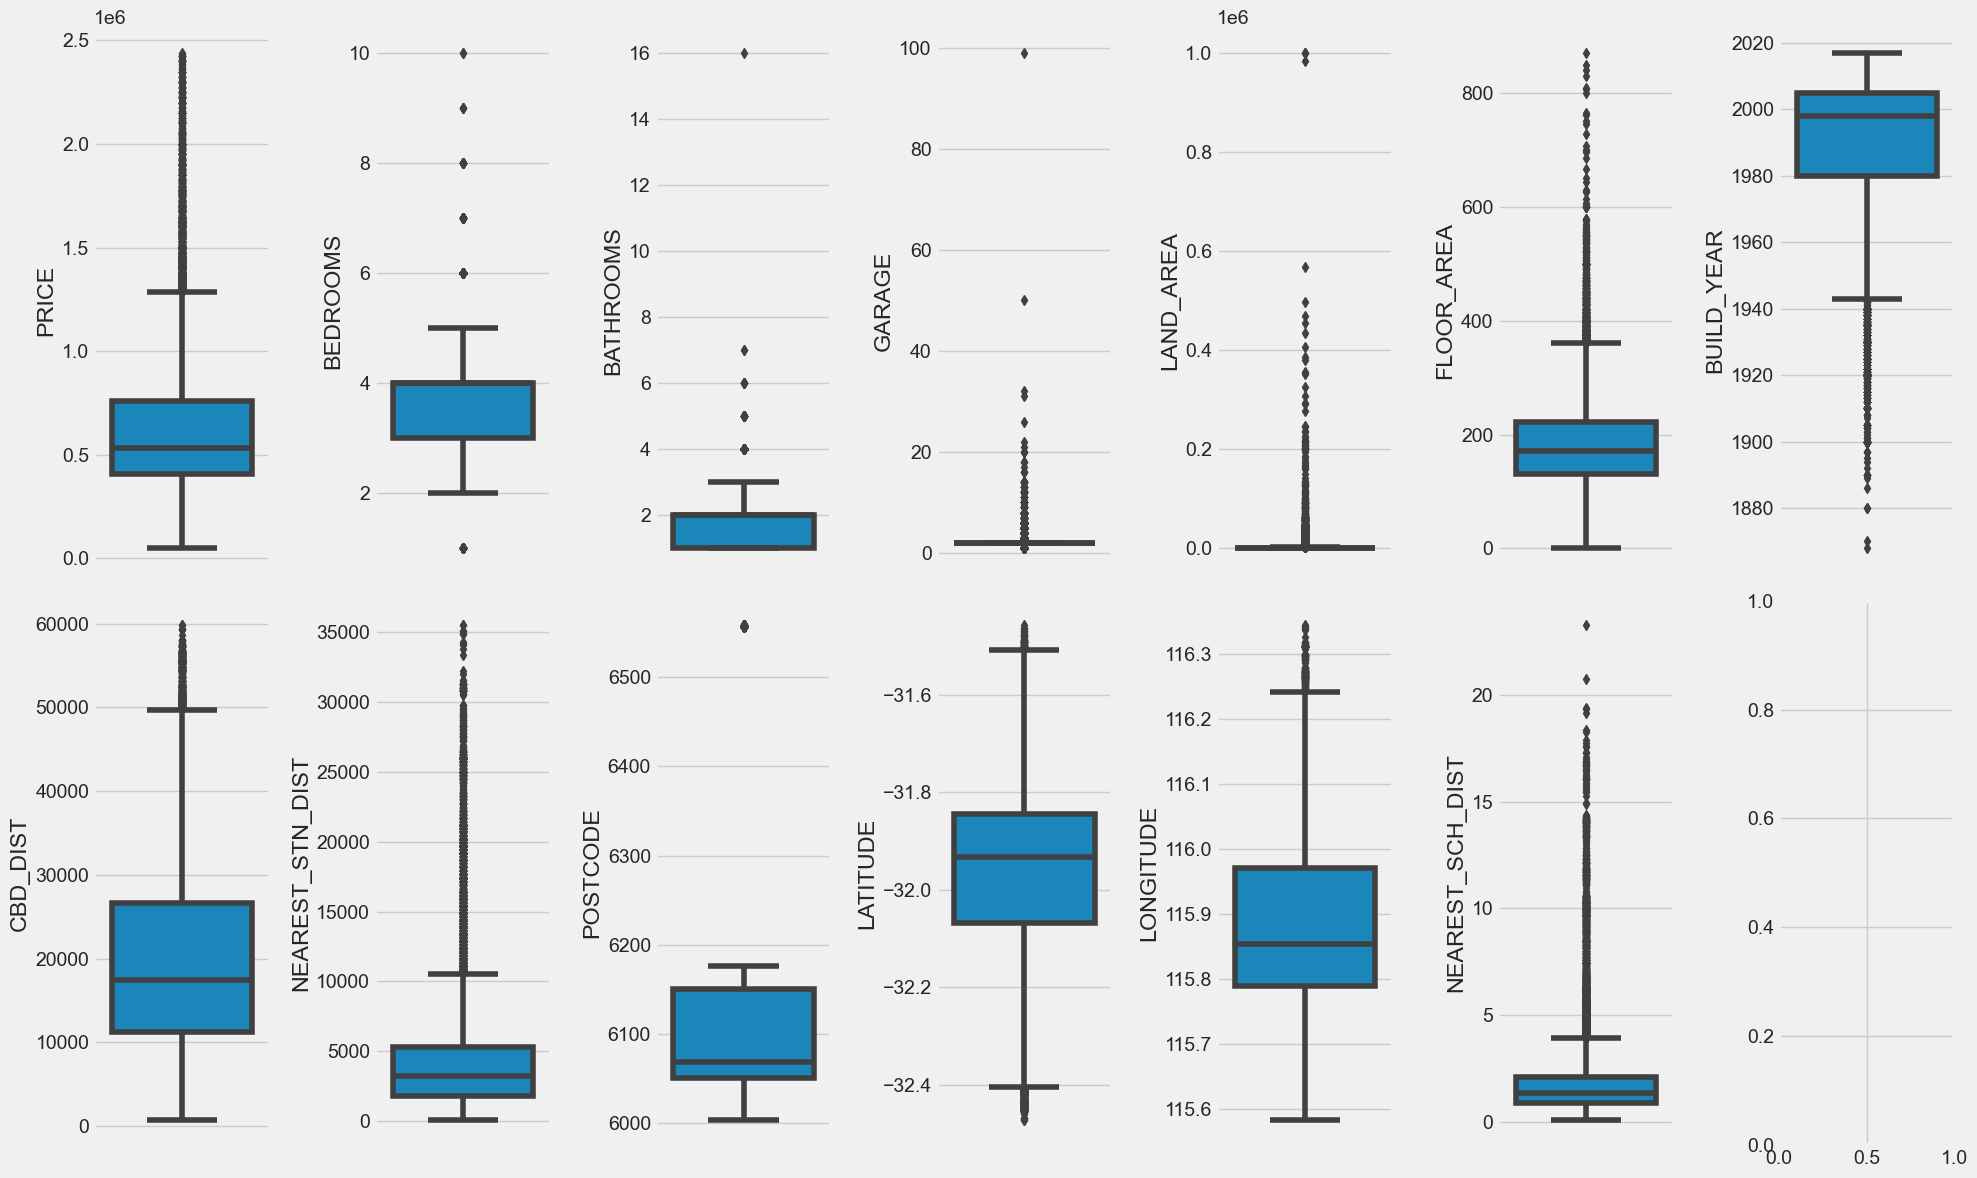

In [25]:
fig,ax=plt.subplots(2,7, figsize=(20,12))
for i,ax in zip(num_cols,ax.ravel()):
    sns.boxplot(y=all_data[i], ax=ax)
    #plt.title("Boxplot of" +i)
plt.tight_layout()
plt.show()

**Conclusions:**

1. PRICE, BUILD_YEAR, NEAREST_STN_DIST, NEAREST_SCH_DIST and CBD_DIST have poor distributions.

2. Many attributes have very different scales.

3. PRICE above $1.5 mln, LAND_AREA above 1500, BUILD_YEAR below 1950, NEAREST_STN_DIST above 10000 and NEAREST_SCH_DIST above 4 will be deleted.

**2. Finding correlations**

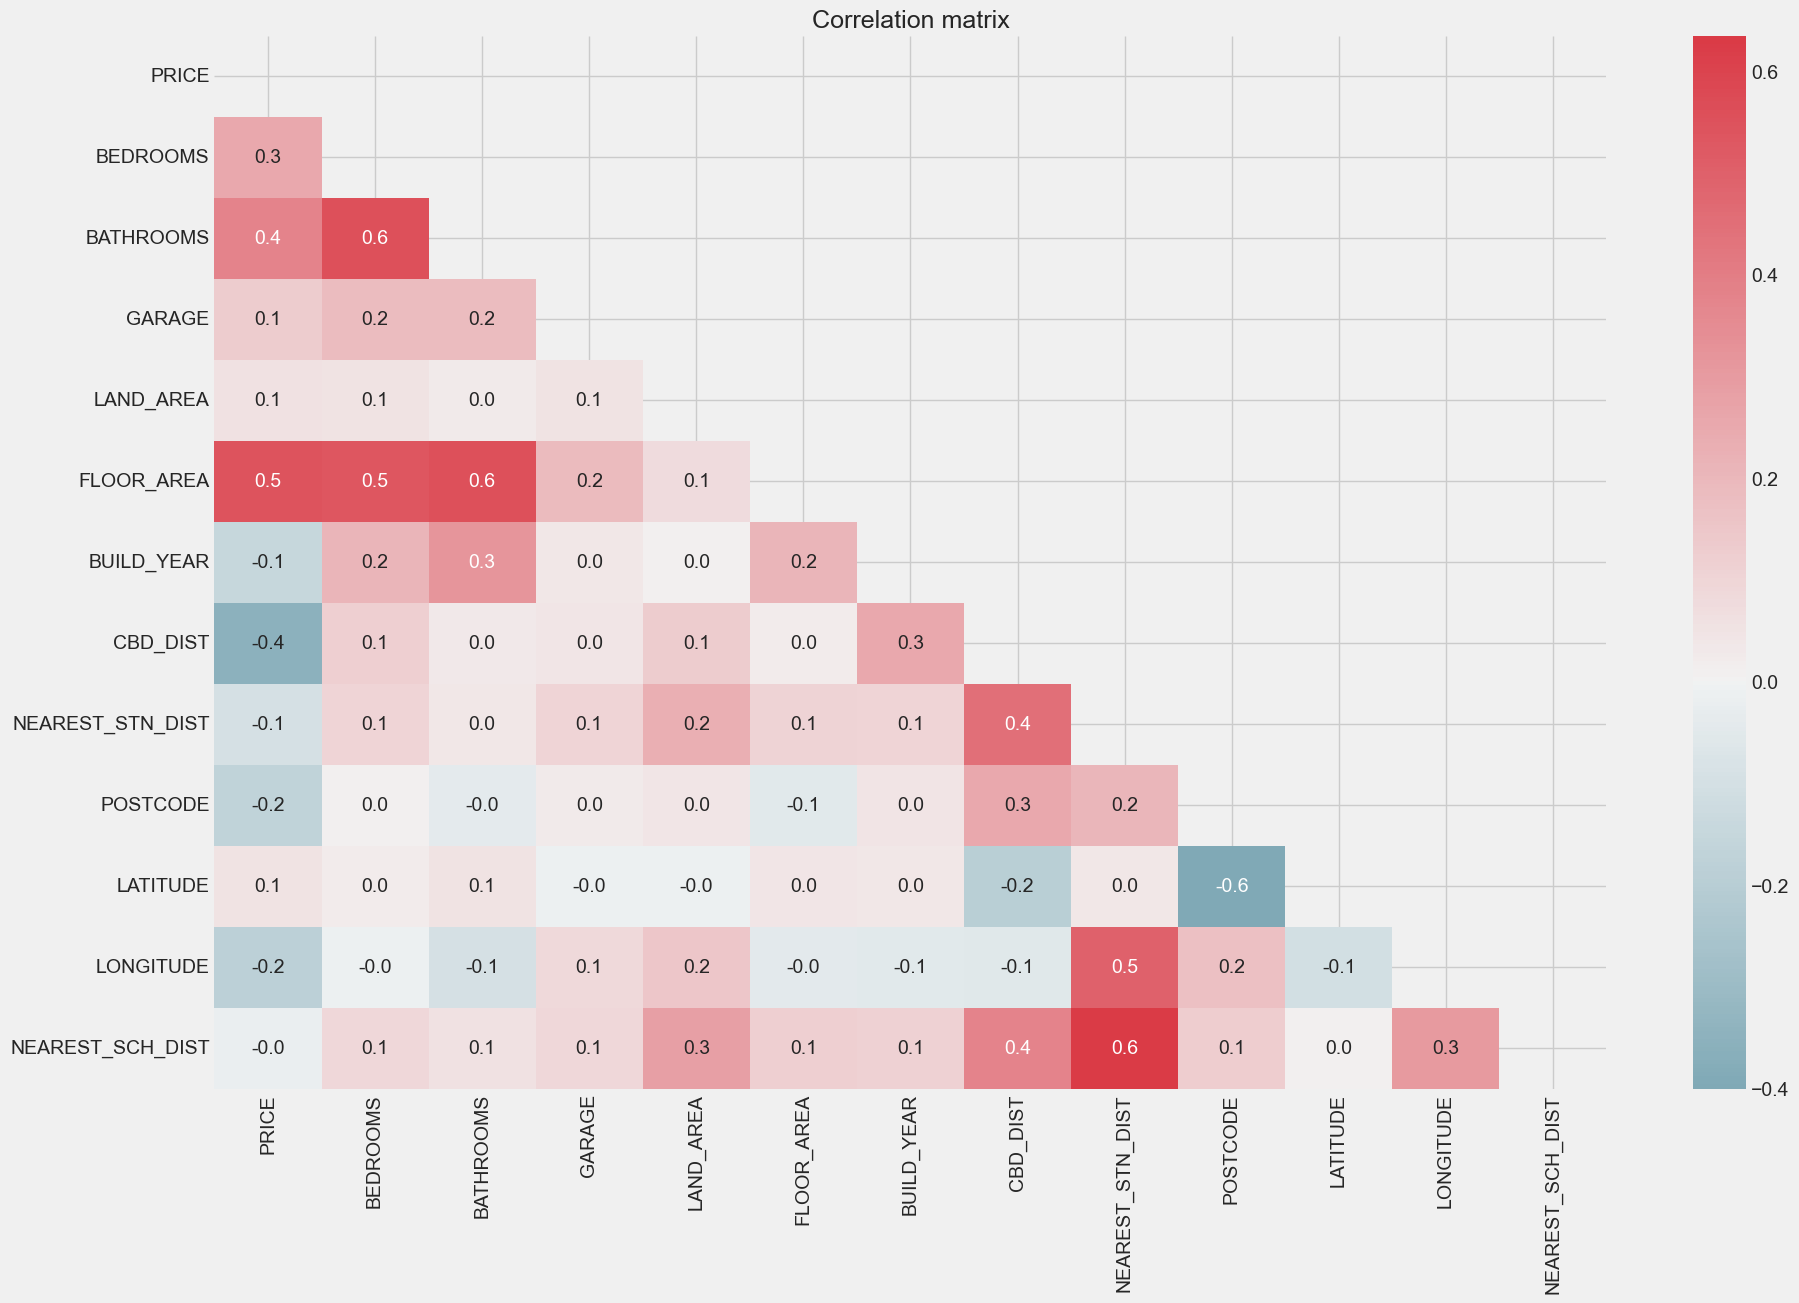

In [26]:
heatmap = all_data[num_cols]
cmap = sns.diverging_palette(220, 10, as_cmap=True)
matrix = np.triu(heatmap.corr())
plt.figure(figsize=(20, 13))
plt.title('Correlation matrix', fontsize=18)
sns.heatmap(heatmap.corr(), annot=True,
            fmt='.1f', vmin=-0.4, center=0, cmap=cmap, mask=matrix)
plt.show()

**Conclusions:**

1. Have corr with PRICE(>0.2): BATHROOMS, BEDROOMS, FLOOR_AREA

2. Have small corr(>=0.1): GARAGE, LAND_AREA, LATITUDE

3. No corr(<=0): NEAREST_SCH_DIST, NEAREST_STN_DIST, BUILD_YEAR, POSTCODE, LONGITUDE, CBD_DIST

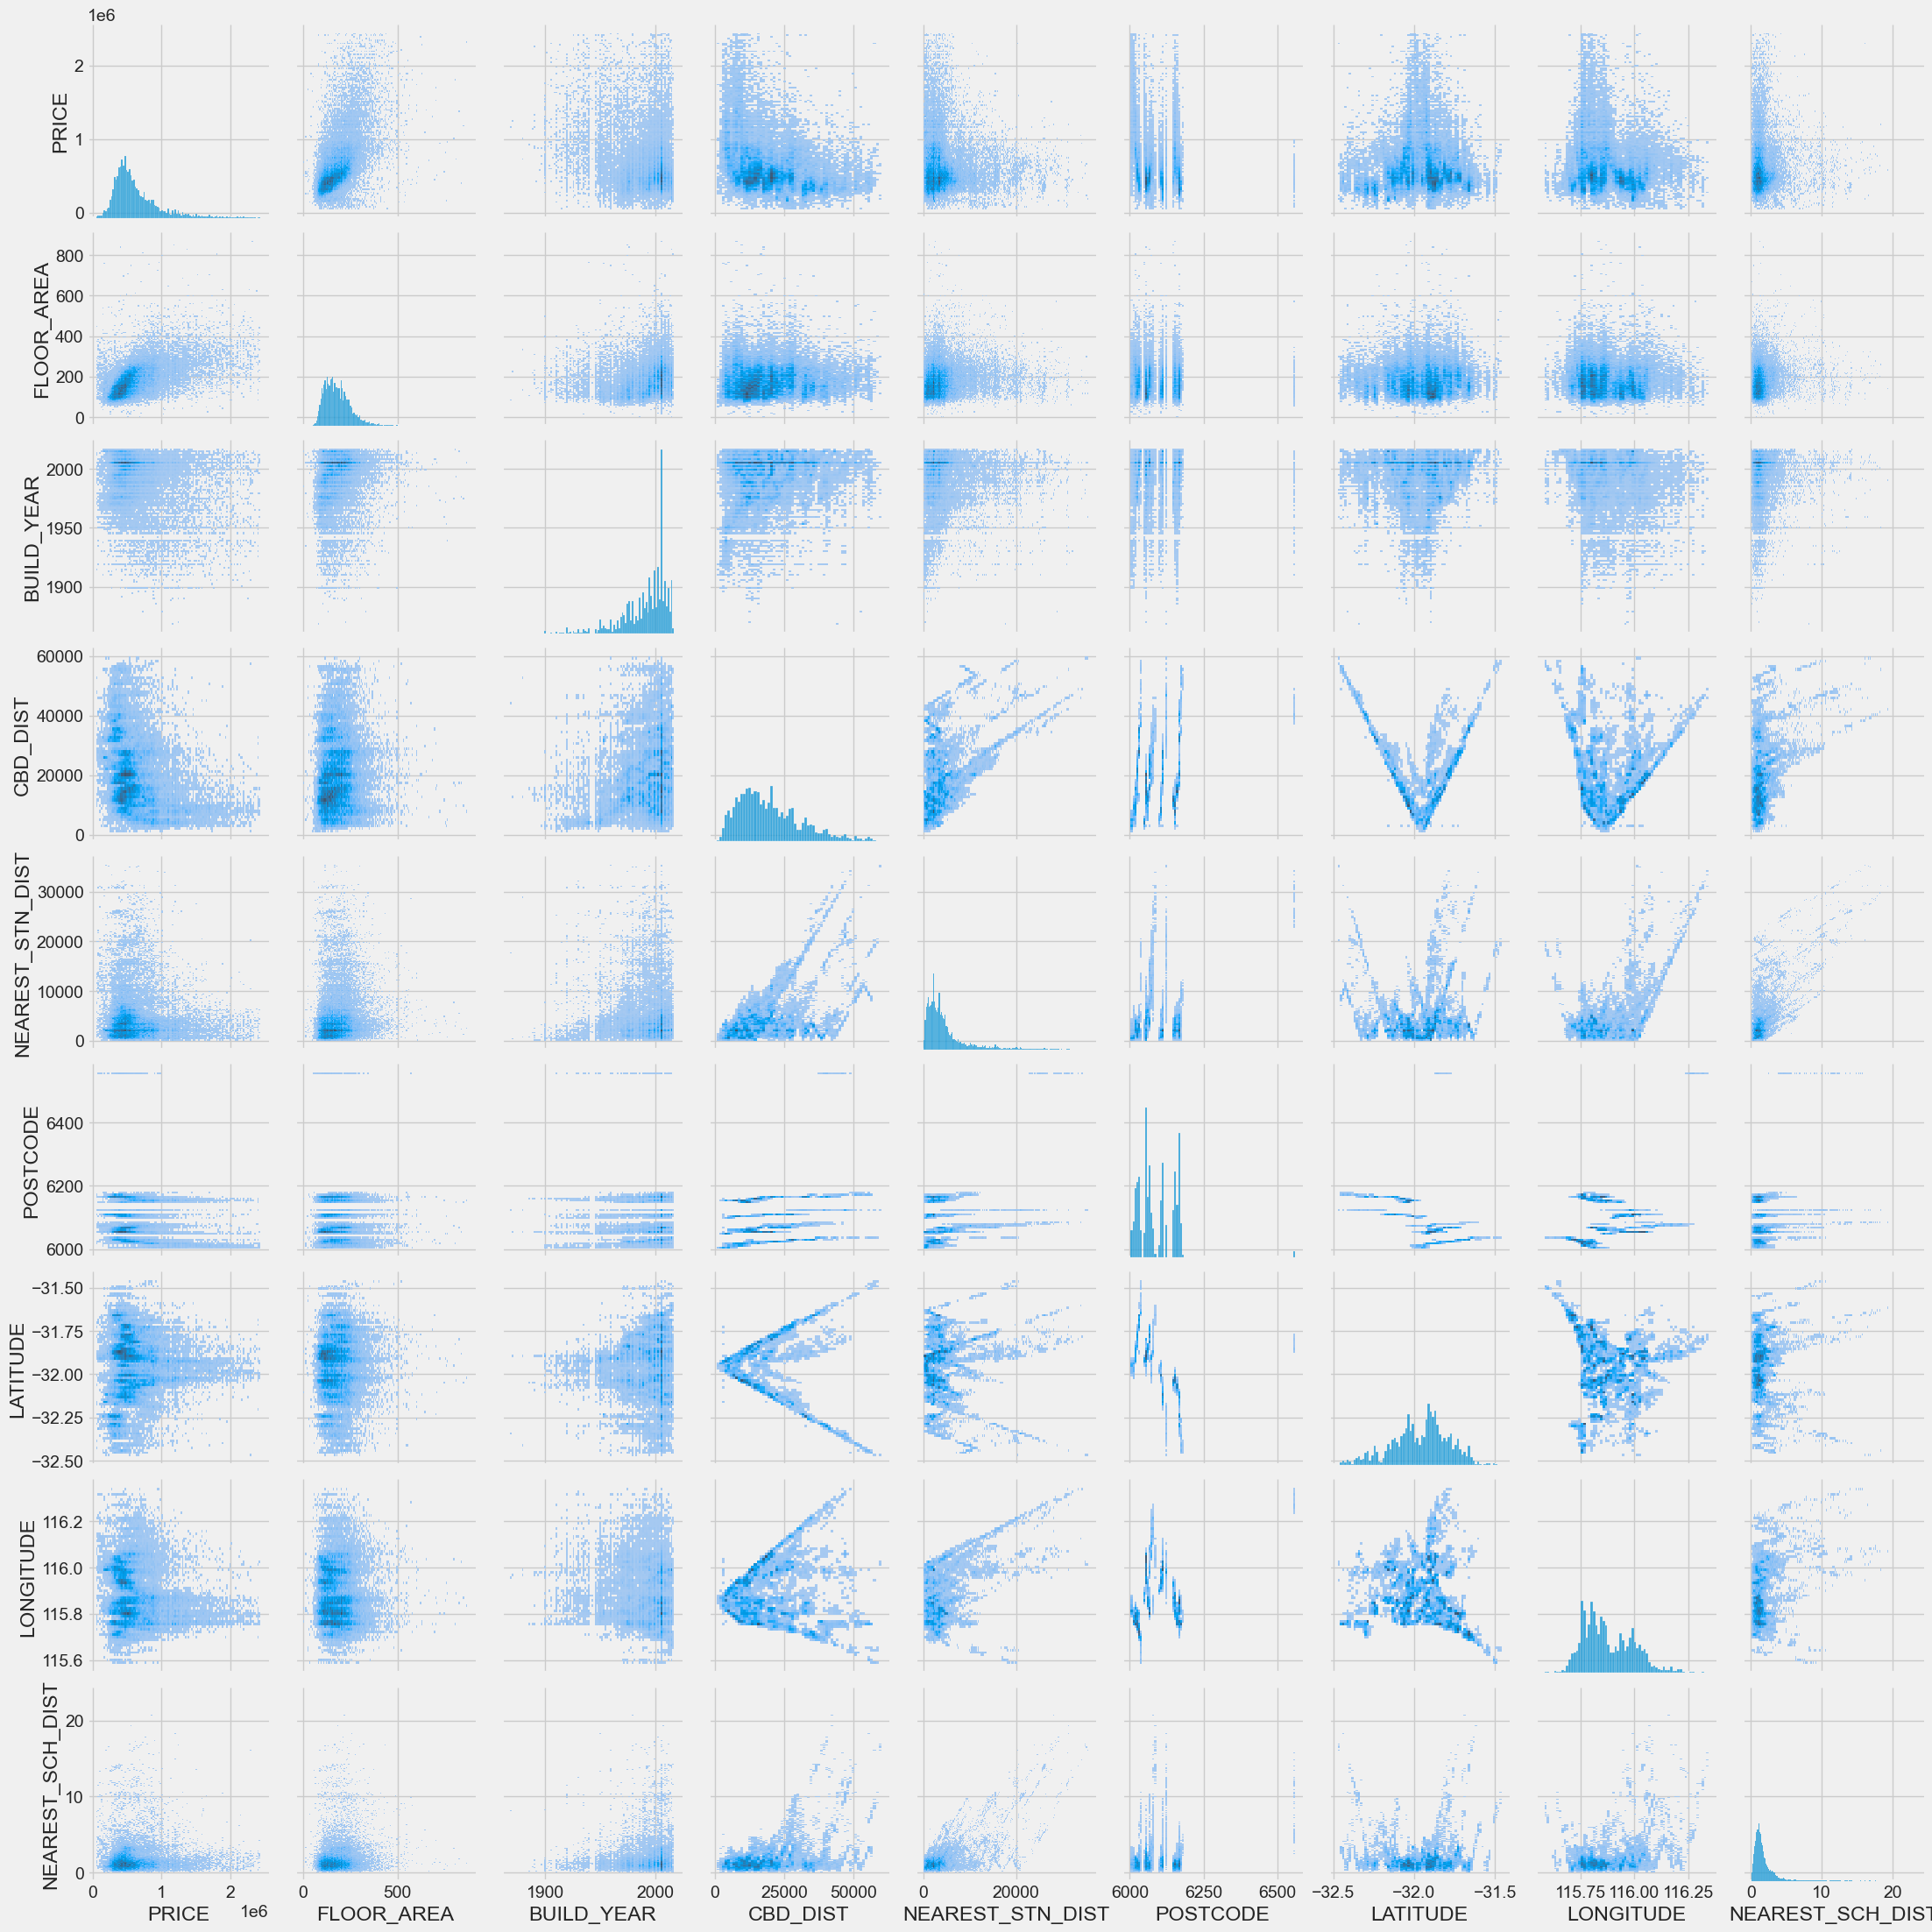

In [30]:
pairplot_columns = ['PRICE', 'FLOOR_AREA', 'BUILD_YEAR', 'CBD_DIST', 
                    'NEAREST_STN_DIST', 'POSTCODE', 'LATITUDE', 'LONGITUDE', 
                    'NEAREST_SCH_DIST']
pairplot1 =all_data[pairplot_columns]
sns.pairplot(pairplot1,kind="hist")
plt.show()

**3. Visualizing Geographical Data (Visualizing how the price increase and decrease by location)**

In [ ]:
#from urllib.request import urlopen
#import json

with urlopen('https://raw.githubusercontent.com/tonywr71/GeoJson-Data/master/australian-states.json') as response:
    australia = json.load(response)

info = geo_df = all_data[['LATITUDE', 'LONGITUDE', 'PRICE', 'ADDRESS', 'BUILD_YEAR']]

fig = px.scatter_mapbox(info, lat='LATITUDE', lon='LONGITUDE', hover_name='ADDRESS', 
    hover_data=['BUILD_YEAR'], color='PRICE',
    zoom=8, height=500, width=1150)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":1,"l":1,"b":1})
fig.show()

**Summary:**

1. Homes with prices above $0.8 million are situated close to the ocean and in the centre of Perth

2. Houses under $0.4 million are located closer to the right side of town or, in general, outside of Perth center

3. Price is affected by the population density

In [12]:
#remove rows where price is above 1.5$ mln

sum_before = all_data['ADDRESS'].count() 

all_data.drop(all_data[all_data['PRICE'] > 1500000].index, inplace=True)

#remove rows where LAND_AREA > 1500, BUILD_YEAR < 1950, NEAREST_STN_DIST > 10000, NEAREST_SCH_DIST > 4
all_data.drop(all_data[all_data['LAND_AREA'] > 1500].index, inplace=True)

all_data.drop(all_data[all_data['BUILD_YEAR'] < 1950].index, inplace=True)

all_data.drop(all_data[all_data['NEAREST_STN_DIST'] > 10000].index, inplace=True)

all_data.drop(all_data[all_data['NEAREST_SCH_DIST'] > 4].index, inplace=True)

#remove rows where year is NaN
all_data.dropna(inplace=True)

sum_after = all_data['ADDRESS'].count()

def percentage_of_deleted_rows(sum_before, sum_after):

    del_rows = sum_before - sum_after

    all_rows = 100
    percentage = (all_rows * sum_after) / sum_before
    
    del_per = float('{:.1f}'.format(all_rows - percentage))

    print(f'Sum of rows before deletion: {sum_before}\nSum of rows after deletion: {sum_after}')
    print(f'Deleted rows: {del_rows}\n')
    print(f'Percentage of deleted rows: {del_per}%')
    

percentage_of_deleted_rows(sum_before, sum_after)

Sum of rows before deletion: 33656
Sum of rows after deletion: 25034
Deleted rows: 8622

Percentage of deleted rows: 25.6%


array([[<Axes: title={'center': 'PRICE'}>,
        <Axes: title={'center': 'BEDROOMS'}>,
        <Axes: title={'center': 'BATHROOMS'}>,
        <Axes: title={'center': 'GARAGE'}>],
       [<Axes: title={'center': 'LAND_AREA'}>,
        <Axes: title={'center': 'FLOOR_AREA'}>,
        <Axes: title={'center': 'BUILD_YEAR'}>,
        <Axes: title={'center': 'CBD_DIST'}>],
       [<Axes: title={'center': 'NEAREST_STN_DIST'}>,
        <Axes: title={'center': 'POSTCODE'}>,
        <Axes: title={'center': 'LATITUDE'}>,
        <Axes: title={'center': 'LONGITUDE'}>],
       [<Axes: title={'center': 'NEAREST_SCH_DIST'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

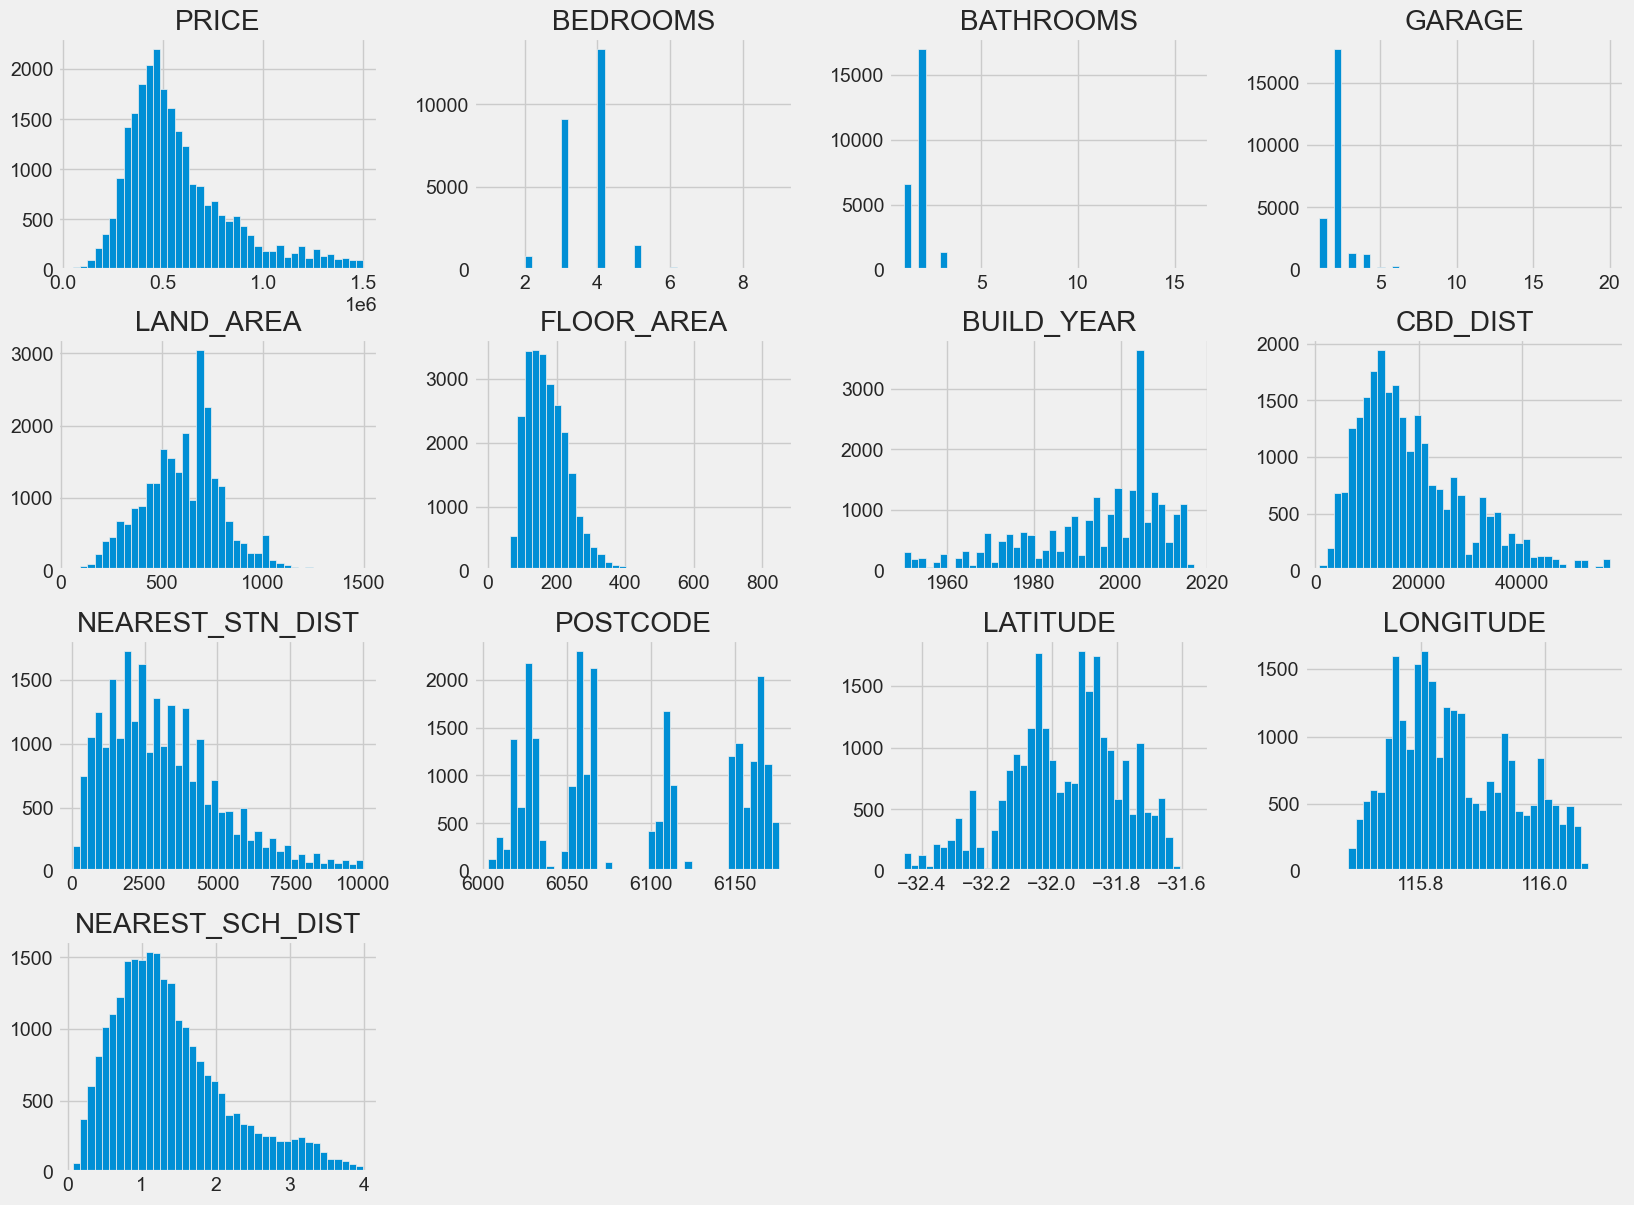

In [13]:
all_data[num_cols].hist(bins=40, figsize=(18,14))

# 5. Creating new features based on the DATA. Experimenting with Attribute Combinations

In [15]:
all_data['FREE_AREA'] = all_data['LAND_AREA'] - all_data['FLOOR_AREA']

all_data['OTHERS_ROOMS_AREA'] = all_data['FLOOR_AREA'] * 0.25

all_data['GARAGE_AREA'] = (all_data['FLOOR_AREA'] - all_data['OTHERS_ROOMS_AREA']) / (all_data['BEDROOMS'] + all_data['BATHROOMS'])
all_data['BATHROOMS_AREA'] = (all_data['FLOOR_AREA'] - all_data['OTHERS_ROOMS_AREA']) / (all_data['BEDROOMS'] + all_data['GARAGE'])
all_data['BEDROOMS_AREA'] = (all_data['FLOOR_AREA'] - all_data['OTHERS_ROOMS_AREA']) / (all_data['BATHROOMS'] + all_data['GARAGE'])

all_data.head(5)

,ADDRESS,SUBURB,PRICE,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,...,POSTCODE,LATITUDE,LONGITUDE,NEAREST_SCH,NEAREST_SCH_DIST,FREE_AREA,OTHERS_ROOMS_AREA,GARAGE_AREA,BATHROOMS_AREA,BEDROOMS_AREA
0,1 Acorn Place,South Lake,565000,4,2,2,600,160,2003,18300,...,6164,-32.1159,115.8424,LAKELAND SENIOR HIGH SCHOOL,0.8283,440,40.0000,20.0000,20.0000,30.0000
2,1 Ainsley Court,Camillo,287000,3,1,1,719,86,1979,22600,...,6111,-32.1206,115.9936,KELMSCOTT SENIOR HIGH SCHOOL,1.6492,633,21.5000,16.1250,16.1250,32.2500
3,1 Albert Street,Bellevue,255000,2,1,2,651,59,1953,17900,...,6056,-31.9005,116.0380,SWAN VIEW SENIOR HIGH SCHOOL,1.5714,592,14.7500,14.7500,11.0625,14.7500
4,1 Aman Place,Lockridge,325000,4,1,2,466,131,1998,11200,...,6054,-31.8858,115.9478,KIARA COLLEGE,1.5149,335,32.7500,19.6500,16.3750,32.7500
5,1 Amethyst Crescent,Mount Richon,409000,4,2,1,759,118,1991,27300,...,6112,-32.1538,116.0237,ARMADALE SENIOR HIGH SCHOOL,1.2272,641,29.5000,14.7500,17.7000,29.5000


In [16]:
#Check how new lebels correlete with PRICE
corr_matrix = all_data.corr()
corr_matrix['PRICE'].sort_values(ascending=False)

/var/folders/jk/vdjcq17n6tq7035g9xsb4j_00000gn/T/ipykernel_61361/3238953962.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



PRICE                1.0000
OTHERS_ROOMS_AREA    0.5779
FLOOR_AREA           0.5779
BATHROOMS_AREA       0.4811
GARAGE_AREA          0.4541
BATHROOMS            0.3709
BEDROOMS_AREA        0.3317
BEDROOMS             0.2470
GARAGE               0.1391
LATITUDE             0.1294
LAND_AREA            0.1045
BUILD_YEAR          -0.0191
NEAREST_SCH_DIST    -0.0521
FREE_AREA           -0.0783
NEAREST_STN_DIST    -0.0951
POSTCODE            -0.1542
LONGITUDE           -0.2649
CBD_DIST            -0.4004
Name: PRICE, dtype: float64

**CONCLUSIONS:**

1. Lebels that have good correlation are added to the data set (OTHERS_ROOMS_AREA, BATHROOMS_AREA, GARAGE_AREA, BEDROOMS_AREA)

2. Lebels that have corr < 1 will be deleted

In [17]:
data = all_data.drop(['FREE_AREA', 'BUILD_YEAR', 'NEAREST_SCH_DIST', 'NEAREST_STN_DIST', 'POSTCODE', 'LONGITUDE', 'CBD_DIST'], axis=1)

# 6. Handling categorical and numerical data(creating preprocessor)

In [18]:
y = data['PRICE']
features = data.drop(['ADDRESS', 'DATE_SOLD', 'PRICE'], axis=1)

num_cols = list(features.select_dtypes(['int64', 'float64']))
print('Numerical Cols: ', num_cols,'\n')

cat_cols = list(features.select_dtypes('object'))
print('Object Cols:', cat_cols)

Numerical Cols:  ['BEDROOMS', 'BATHROOMS', 'GARAGE', 'LAND_AREA', 'FLOOR_AREA', 'LATITUDE', 'OTHERS_ROOMS_AREA', 'GARAGE_AREA', 'BATHROOMS_AREA', 'BEDROOMS_AREA'] 

Object Cols: ['SUBURB', 'NEAREST_STN', 'NEAREST_SCH']


**Creating Preprocessor**

In [19]:
#numerical_transformer = SimpleImputer(strategy='constant')
numerical_transformer = MinMaxScaler(feature_range=(0,1))
"""
used to test 

categorical_transformer = Pipeline(steps=[
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])
"""
"""
used to test 

categorical_transformer = Pipeline(steps=[
    ('count_encoder', ce.CountEncoder())
])
"""
#The best way to encode categorical data is to use CatBoostEncoder
categorical_transformer = Pipeline(steps=[
    ('cat_encoder', ce.CatBoostEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

# 7. Models building and choosing the best model

In [27]:
#spliting data into train data and test data
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=21)

In [23]:
models = {
    'RandomForestRegressor' :RandomForestRegressor(),
    'Ridge' :Ridge(), 
    'XGBRegressor' :XGBRegressor(),
}

mae_results = []
r2_results = []
model_names = []
rmse_results = []


for name, model in models.items():

    pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)])

    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    mae_score = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    rmse_score = np.sqrt(mean_squared_error(y_test, predictions))
    
    mae_results.append(mae_score)
    r2_results.append(r2)
    model_names.append(name)
    rmse_results.append(rmse_score)

results = pd.DataFrame([model_names, rmse_results, mae_results, r2_results])
results = results.transpose()
results = results.rename(columns={0:'Model',1:'RMSE',2:'MAE', 3:'R2 Score'}).sort_values(by='RMSE',ascending=True)
results

,Model,RMSE,MAE,R2 Score
0,RandomForestRegressor,104109.3779,70163.9108,0.8454
2,XGBRegressor,107556.8989,71776.0643,0.8350
1,Ridge,114614.6875,80595.9827,0.8126


**The best performance shows RandomForestRegression**

# 8. Model Tuning

**RandomForestRegression**

In [24]:
final_model = RandomForestRegressor(n_estimators=400, max_features=8, max_depth=16)

final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', final_model)])

final_pipeline.fit(X_train, y_train)
final_preds = final_pipeline.predict(X_test)

model_results = pd.DataFrame([y_test.values, final_preds])
model_results = model_results.transpose()
model_results = model_results.rename(columns={0:'Actual Price',1:'Predicted Price'})

print(model_results.describe(),'\n')
print("RMSE:", round(np.sqrt(mean_squared_error(model_results['Actual Price'], model_results['Predicted Price'])), 1),'\n')
print("MAE:", round(mean_absolute_error(model_results['Actual Price'], model_results['Predicted Price']), 1),'\n')
print("R2 score:", round(r2_score(model_results['Actual Price'], model_results['Predicted Price']), 2))

       Actual Price  Predicted Price
count     5007.0000        5007.0000
mean    576041.6525      580387.6459
std     264799.5411      246086.2222
min      61000.0000      164101.6489
25%     397500.0000      402637.3087
50%     510000.0000      514765.2604
75%     695000.0000      697383.7629
max    1500000.0000     1372085.8103 

RMSE: 103227.7 

MAE: 69474.8 

R2 score: 0.85


In [25]:
final_model_scores = cross_val_score(final_pipeline, X_train, y_train,
                              cv=5,
                              scoring='r2')

print(f'Mean R2 scores: {round(np.mean(final_model_scores), 2)}')

Mean R2 scores: 0.84


# 9. Results

<Axes: ylabel='Density'>

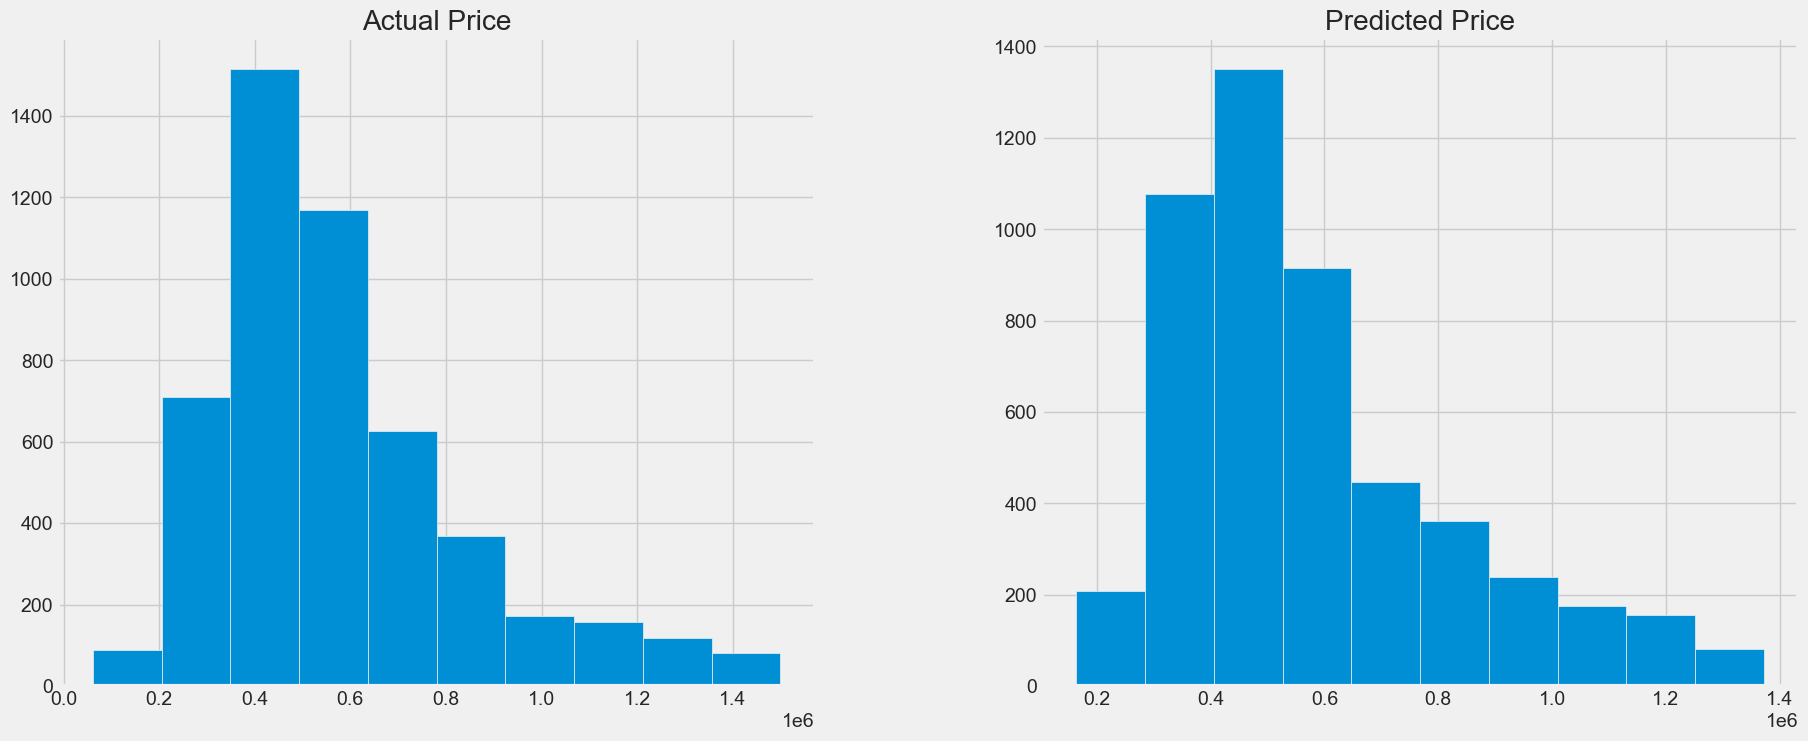

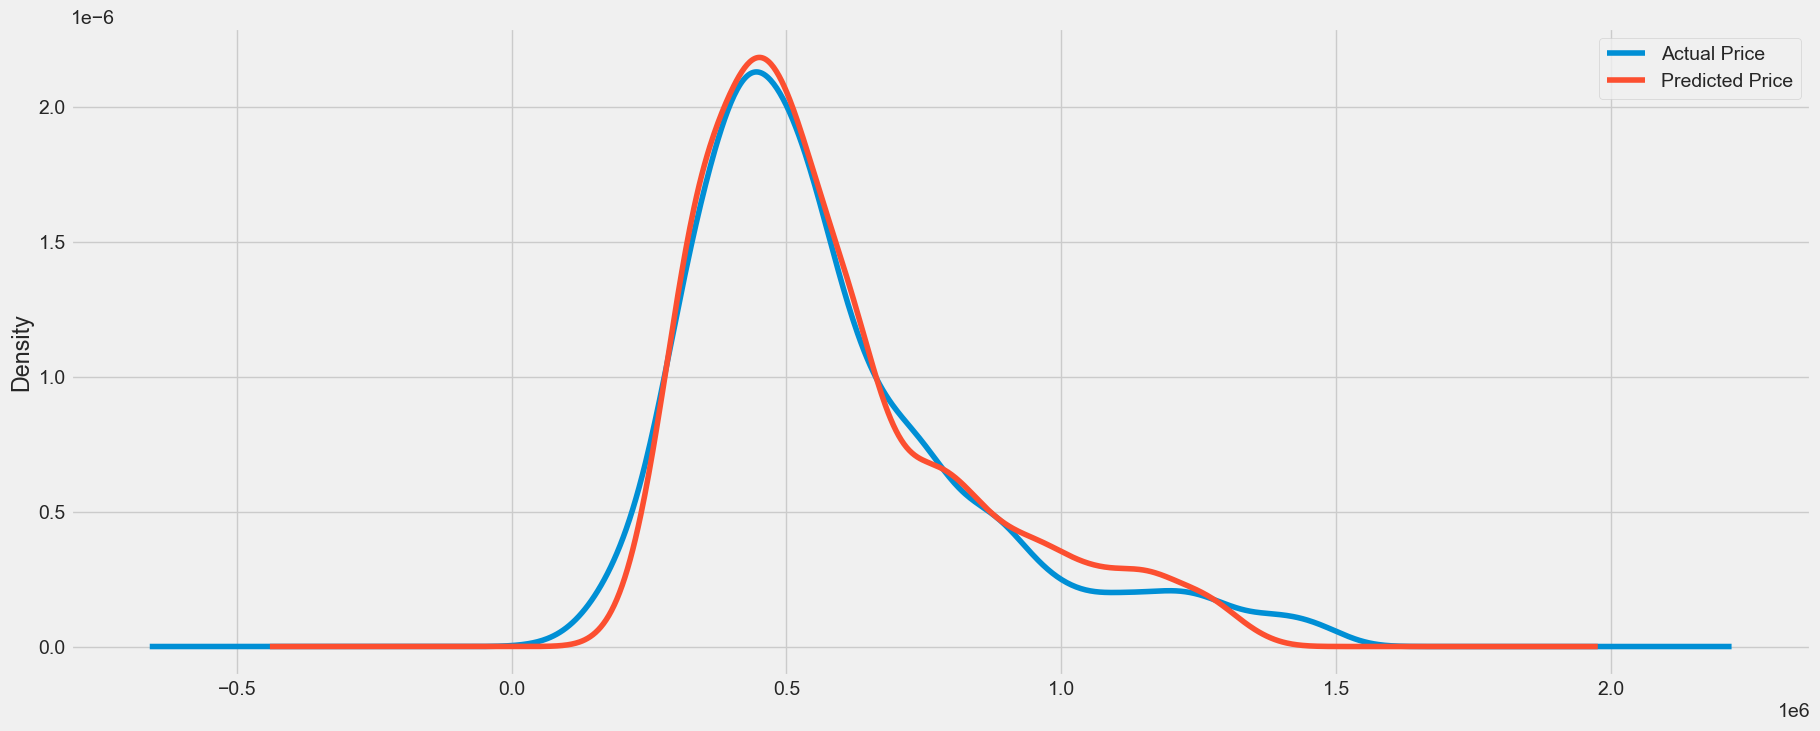

In [26]:
model_results.hist(figsize=(20, 8))
model_results.plot(kind='kde', figsize=(20, 8))

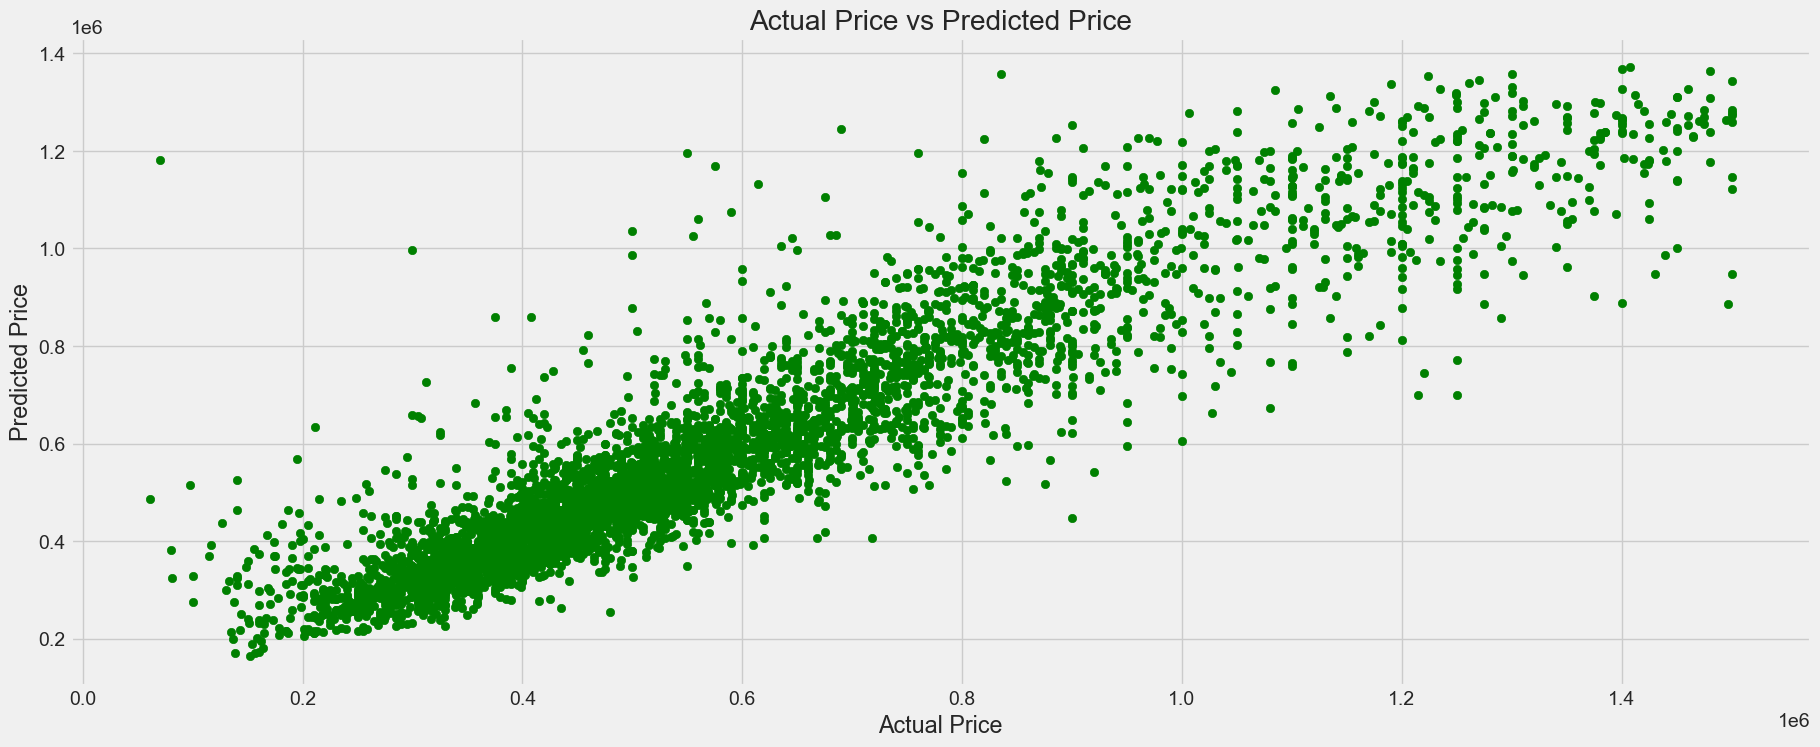

In [27]:
# scatterplot of actual price vs predicted price   
plt.figure(figsize=(20, 8)) 
plt.scatter(model_results['Actual Price'], model_results['Predicted Price'], color='green')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual Price vs Predicted Price')    
plt.show()

                                                            I HOPE YOU ENJOY MY WORK!!!
                                                            
                                                 P.S Please leave comments on how to improve the notebook)